## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple

import os
from pathlib import Path
import re
import json
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Enrich long_df with parsed model metadata
from dataclasses import dataclass
from typing import Optional as _Optional

## Helper functions and utils

In [2]:

# Contract
# inputs: dict model_name -> path (folder containing per-assay CSVs or nested)
# outputs: DataFrame (rows=models, cols=assays), long-form DataFrame for plotting
# error modes: missing columns, empty CSVs, mismatched lengths handled gracefully

ASSAY_ID_COL_CANDIDATES = [
    'DMS_id', 'Assay', 'assay', 'assay_id'
]
TRUTH_COL_CANDIDATES = [
    'DMS_score', 'ground_truth', 'y', 'fitness', 'label'
]
# Model score column will be inferred per CSV based on presence of columns other than standard ones.

CSV_GLOB = r"**/*.csv"


def _infer_assay_id(df: pd.DataFrame, default_from_path: str) -> str:
    for c in ASSAY_ID_COL_CANDIDATES:
        if c in df.columns and pd.api.types.is_string_dtype(df[c]):
            vals = df[c].dropna().unique()
            if len(vals) == 1:
                return str(vals[0])
    # fallback to filename stem
    return default_from_path


def _find_truth_col(df: pd.DataFrame) -> str:
    for c in TRUTH_COL_CANDIDATES:
        if c in df.columns and np.issubdtype(df[c].dtype, np.number):
            return c
    # Also try "DMS_score_Binarized" seen in some exports
    for c in df.columns:
        if c.lower() in {"dms_score", "dms_score_binarized", "true", "target"} and np.issubdtype(df[c].dtype, np.number):
            return c
    raise ValueError("No numeric ground-truth column found in candidates.")


def _find_model_score_cols(df: pd.DataFrame) -> List[str]:
    # Heuristic: numeric columns that are not index-like and not truth
    numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    truth = set([_find_truth_col(df)]) if any(c in df.columns for c in TRUTH_COL_CANDIDATES) else set()
    ignore = set(['position', 'pos', 'i', 'j', 'k']) | truth
    score_cols = [c for c in numeric_cols if c not in ignore]
    return score_cols


def iter_assay_csvs(root: Path) -> List[Path]:
    return sorted([p for p in root.glob(CSV_GLOB) if p.is_file()])


def compute_spearman_for_file(model_name: str, csv_path: Path):
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return None
    if df.empty:
        return None
    try:
        truth_col = _find_truth_col(df)
    except Exception:
        return None
    assay_id = _infer_assay_id(df, default_from_path=csv_path.stem)
    score_cols = _find_model_score_cols(df)
    if not score_cols:
        return None
    chosen = None
    for c in score_cols:
        if model_name == c or model_name in c:
            chosen = c
            break
    if chosen is None:
        chosen = [c for c in score_cols if c != truth_col][-1] if len(score_cols) > 1 else score_cols[0]
    x = df[truth_col].astype(float)
    y = df[chosen].astype(float)
    if len(x) < 2:
        return None
    rho = spearmanr(x, y, nan_policy='omit').correlation
    if pd.isna(rho):
        return None
    return {"stem": csv_path.stem, "assay": str(assay_id), "spearman": float(rho)}


def compute_spearman_per_assay(model_name: str, model_root: Path) -> List[Tuple[str, float]]:
    # Backward-compatible full recompute
    results: List[Tuple[str, float]] = []
    for csv_path in iter_assay_csvs(model_root):
        rec = compute_spearman_for_file(model_name, csv_path)
        if rec is not None:
            results.append((rec["assay"], rec["spearman"]))
    return results


def _cache_dir(root: Path) -> Path:
    cd = root / "_analysis_cache"
    cd.mkdir(exist_ok=True, parents=True)
    return cd

def _cache_file_for_model(root: Path, model_name: str) -> Path:
    # safe filename
    safe = re.sub(r"[^A-Za-z0-9_.-]", "_", model_name)
    return _cache_dir(root) / f"spearman_{safe}.csv"

def load_cached_spearman_full(root: Path, model_name: str) -> pd.DataFrame | None:
    f = _cache_file_for_model(root, model_name)
    if f.exists():
        try:
            cdf = pd.read_csv(f)
            if {'assay','spearman'}.issubset(set(cdf.columns)):
                cdf['assay'] = cdf['assay'].astype(str)
                if 'stem' in cdf.columns:
                    cdf['stem'] = cdf['stem'].astype(str)
                return cdf
        except Exception:
            return None
    return None

def save_cached_spearman_df(root: Path, model_name: str, cdf: pd.DataFrame) -> None:
    f = _cache_file_for_model(root, model_name)
    cols = ['stem','assay','spearman'] if 'stem' in cdf.columns else ['assay','spearman']
    cdf.loc[:, cols].to_csv(f, index=False)


def evaluate_models(model_paths: Dict[str, str], public_benchmark: pd.DataFrame, *, recompute: bool = False, cache_root: Path | None = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    wide = {}
    long_rows = []
    base_root = cache_root if cache_root is not None else Path.cwd()
    for name, path in model_paths.items():
        if path == "precomputed":
            # Look for model name in public benchmark
            if name in public_benchmark.columns:
                for assay in public_benchmark.index:
                    rho = public_benchmark.loc[assay, name]
                    if not pd.isna(rho):
                        wide.setdefault(name, {})[assay] = rho
                        long_rows.append({"model": name, "assay": assay, "spearman": rho})
        else:
            root = Path(path)
            expected_stems = [p.stem for p in iter_assay_csvs(root)]
            cdf = None if recompute else load_cached_spearman_full(root, name)
            if cdf is None or cdf.empty:
                # No usable cache: compute all
                rows = []
                for csv_path in iter_assay_csvs(root):
                    rec = compute_spearman_for_file(name, csv_path)
                    if rec is not None:
                        rows.append(rec)
                cdf = pd.DataFrame(rows, columns=["stem","assay","spearman"]) if rows else pd.DataFrame(columns=["stem","assay","spearman"])
                save_cached_spearman_df(root, name, cdf)
            else:
                # Cache exists: verify completeness by file stem
                cached_stems = set(cdf["stem"].astype(str)) if "stem" in cdf.columns else set(cdf["assay"].astype(str))
                missing = [s for s in expected_stems if s not in cached_stems]
                if missing:
                    new_rows = []
                    for csv_path in iter_assay_csvs(root):
                        if csv_path.stem in missing:
                            rec = compute_spearman_for_file(name, csv_path)
                            if rec is not None:
                                new_rows.append(rec)
                    if new_rows:
                        new_df = pd.DataFrame(new_rows)
                        if "stem" not in cdf.columns:
                            cdf["stem"] = cdf["assay"]
                        cdf = pd.concat([cdf, new_df], ignore_index=True)
                        cdf = cdf.drop_duplicates(subset=["stem"], keep="first")
                        save_cached_spearman_df(root, name, cdf)
            # Fill outputs from cache (complete or completed)
            pairs = [(str(a), float(r)) for a, r in zip(cdf["assay"], cdf["spearman"]) ]
            wide[name] = {assay: rho for assay, rho in pairs}
            for assay, rho in pairs:
                long_rows.append({"model": name, "assay": assay, "spearman": rho})
    wide_df = pd.DataFrame(wide).T.sort_index()
    long_df = pd.DataFrame(long_rows)
    return wide_df, long_df

In [3]:
def parse_model_name(name: str) -> dict:
    # Pattern: PREFIX_DATASET_THRESHOLD(_subX)?(_1m)?
    m = re.match(
        r"^(?P<prefix>[A-Za-z]+)_(?P<dataset>[A-Za-z0-9]+)_(?P<threshold>\d+\.\d+)"
        r"(?:_(?P<sub>sub\d+))?(?:_(?P<long>1m))?$",
        name
    )
    if m:
        d = m.groupdict()
        threshold = float(d.get("threshold")) if d.get("threshold") is not None else None
        sub_raw = d.get("sub") or ""
        sub_ratio = None
        if sub_raw.startswith("sub") and len(sub_raw) > 3:
            try:
                sub_ratio = int(sub_raw[3:])
            except Exception:
                sub_ratio = None
        long_training = (d.get("long") == "1m")
        steps = "1m" if long_training else "100k"
        return {
            "prefix": d.get("prefix"),
            "dataset": d.get("dataset"),
            "threshold": threshold,
            "sub_ratio": sub_ratio,
            "long_training": long_training,
            "steps": steps,
        }

    # Fallback: PREFIX_DATASET only -> threshold 0.0, steps=100k, sub_ratio=NaN
    m2 = re.match(r"^(?P<prefix>[A-Za-z]+)_(?P<dataset>[A-Za-z0-9]+)$", name)
    if m2:
        d = m2.groupdict()
        return {
            "prefix": d.get("prefix"),
            "dataset": d.get("dataset"),
            "threshold": 0.0,
            "sub_ratio": np.nan,
            "long_training": False,
            "steps": "100k",
        }

    return {
        "prefix": None,
        "dataset": None,
        "threshold": None,
        "sub_ratio": None,
        "long_training": None,
        "steps": None,
    }


In [4]:
# Display settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid')

## Load results data

In [5]:
# Define your models here: { name: folder_with_csvs }
# Example:
# model_paths = {
#     "AMPLIFY-large": "/path/to/outputs/AMPLIFY-large",
#     "AnotherModel": "/path/to/outputs/AnotherModel"
# }

all_result_paths = "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/AMPLIFY_2/120M/"
all_models = sorted(os.listdir(all_result_paths))

model_paths = {model: os.path.join(all_result_paths, model) for model in all_models}
colors = sns.color_palette("Blues", n_colors=len(model_paths))


In [6]:
# Load the previous results (all other public models)
repo_root = Path.cwd().parent
dms_substitutions_df = pd.read_csv(repo_root / "benchmarks/DMS_zero_shot/substitutions/Spearman/DMS_substitutions_Spearman_DMS_level.csv", index_col=0)

In [7]:
dms_substitutions_df.head() # Structure is index is DMS id, columsn are model names

,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),MSA Transformer (ensemble),ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B),Wavenet,RITA S,RITA M,RITA L,RITA XL,Progen2 S,Progen2 M,Progen2 Base,Progen2 L,Progen2 XL,GEMME,VESPA,VESPAl,VespaG,ProtGPT2,Tranception S no retrieval,Tranception M no retrieval,Tranception L no retrieval,Tranception S,Tranception M,Tranception L,TranceptEVE S,TranceptEVE M,TranceptEVE L,CARP (38M),CARP (600K),CARP (640M),CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,"ProtSSN (k=10, h=512)","ProtSSN (k=10, h=768)","ProtSSN (k=10, h=1280)","ProtSSN (k=20, h=512)","ProtSSN (k=20, h=768)","ProtSSN (k=20, h=1280)","ProtSSN (k=30, h=512)","ProtSSN (k=30, h=768)","ProtSSN (k=30, h=1280)",ProtSSN (ensemble),SaProt (650M),SaProt (35M),PoET (200M),MULAN,ProSST (K=20),ProSST (K=128),ProSST (K=512),ProSST (K=1024),ProSST (K=2048),ProSST (K=4096),ESCOTT,VenusREM,RSALOR,S2F,S2F-MSA,S3F,S3F-MSA,SiteRM,ESM3 open (1.4B),ESM-C (300M),ESM-C (600M),xTrimoPGLM-1B-MLM,xTrimoPGLM-3B-MLM,xTrimoPGLM-10B-MLM,xTrimoPGLM-1B-CLM,xTrimoPGLM-3B-CLM,xTrimoPGLM-7B-CLM,xTrimoPGLM-100B-int4,Progen3 112m,Progen3 219m,Progen3 339m,Progen3 762m,Progen3 1B,Progen3 3B,AIDO Protein-RAG (16B),Protriever,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon
DMS ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.436,0.439,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375,0.216,0.361,0.309,0.317,0.305,0.329,0.342,0.328,0.312,0.293,0.430,0.319,0.296,0.380,0.005,0.304,0.331,0.272,0.362,0.366,0.351,0.361,0.358,0.373,-0.060,-0.073,0.131,-0.061,0.273,0.290,0.287,0.129,0.253,0.251,0.282,0.296,0.277,0.269,0.263,0.269,0.265,0.278,0.199,0.116,0.429,0.071,0.107,0.102,0.113,0.113,0.280,0.112,0.471,0.387,0.423,0.285,0.402,0.308,0.418,0.415,0.277,-0.058,-0.048,-0.048,0.366,0.373,0.332,0.282,-0.024,0.303,0.032,0.191,0.305,0.298,0.354,0.338,0.427,0.477,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus
A0A192B1T2_9HIV1_Haddox_2018,0.481,0.407,0.413,0.432,0.509,0.516,0.000,0.513,0.511,0.515,0.456,0.492,0.516,-0.003,0.015,0.035,0.080,0.132,0.164,0.465,0.496,0.507,0.509,0.505,0.497,0.501,0.463,0.490,0.484,0.496,0.541,0.507,0.299,0.327,0.492,0.483,0.514,0.509,0.503,0.513,0.524,0.518,0.528,0.422,-0.021,0.497,0.429,0.329,0.451,0.206,0.136,0.202,0.230,0.258,0.263,0.210,0.226,0.228,0.200,0.183,0.239,0.173,0.084,0.488,0.051,0.341,0.383,0.382,0.404,0.447,0.419,0.522,0.562,0.532,0.307,0.523,0.365,0.552,0.515,0.257,0.478,0.460,0.488,0.521,0.466,0.476,0.332,0.024,0.334,0.409,0.482,0.471,0.473,0.487,0.499,0.595,0.504,12577,OrganismalFitness,A0A192B1T2_9HIV1,Medium,Virus
A0A1I9GEU1_NEIME_Kennouche_2019,-0.011,0.044,0.107,0.098,0.053,0.054,-0.024,0.084,0.082,0.077,0.040,0.068,0.068,-0.037,-0.047,-0.016,0.030,0.027,0.025,0.067,-0.010,0.047,0.071,0.088,0.050,0.088,0.080,0.089,0.095,0.045,0.046,0.036,0.033,0.030,0.036,0.055,0.099,0.031,0.041,0.057,0.058,0.061,0.075,-0.055,-0.056,0.039,-0.043,0.051,0.055,0.039,0.040,0.054,0.042,0.039,0.035,0.037,0.052,0.039,0.058,0.041,0.047,0.040,-0.005,0.057,-0.016,0.146,0.177,0.199,0.176,0.076,0.182,0.041,0.070,-0.010,0.043,0.055,0.049,0.058,0.061,0.025,0.058,0.051,0.042,0.051,0.053,0.061,0.020,0.037,0.065,-0.019,0.008,0.043,0.059,0.088,0.094,0.064,0.056,922,Activity,A0A1I9GEU1_NEIME,Medium,Prokaryote
A0A247D711_LISMN_Stadelmann_2021,0.436,0.459,0.109,0.041,0.428,0.428,0.003,0.026,0.299,0.320,0.087,0.088,0.093,0.064,0.084,0.097,0.066,0.084,0.084,0.059,0.021,0.015,0.040,0.078,-0.029,0.067,0.010,0.037,0.106,0.473,0.337,0.351,0.382,0.093,0.041,0.024,0.057,0.301,0.292,0.311,0.253,0.242,0.263,0.047,0.002,0.074,0.084,0.418,0.441,0.476,0.364,0.274,0.326,0.314,0.344,0.313,0.360,0.312,0.331,0.265,0.335,0.427,0.280,0.458,0.162,0.450,0.476,0

In [8]:
if not model_paths:
    print("Please set 'model_paths' to your result folders (each containing per-assay CSVs).")
else:
    # Toggle recompute to True to force refresh of cached per-assay Spearman scores
    recompute = False
    wide_df, long_df = evaluate_models(model_paths, dms_substitutions_df, recompute=recompute)
    display(wide_df)
    print(f"Total assays with results: {long_df['assay'].nunique()} across {long_df['model'].nunique()} models")

,A0A140D2T1_ZIKV_Sourisseau_2019,A0A192B1T2_9HIV1_Haddox_2018,A0A1I9GEU1_NEIME_Kennouche_2019,A0A247D711_LISMN_Stadelmann_2021,A0A2Z5U3Z0_9INFA_Doud_2016,A0A2Z5U3Z0_9INFA_Wu_2014,A4D664_9INFA_Soh_2019,A4GRB6_PSEAI_Chen_2020,A4_HUMAN_Seuma_2022,AACC1_PSEAI_Dandage_2018,ACE2_HUMAN_Chan_2020,ADRB2_HUMAN_Jones_2020,AICDA_HUMAN_Gajula_2014_3cycles,AMFR_HUMAN_Tsuboyama_2023_4G3O,AMIE_PSEAE_Wrenbeck_2017,ANCSZ_Hobbs_2022,ARGR_ECOLI_Tsuboyama_2023_1AOY,B2L11_HUMAN_Dutta_2010_binding-Mcl-1,BBC1_YEAST_Tsuboyama_2023_1TG0,BCHB_CHLTE_Tsuboyama_2023_2KRU,BLAT_ECOLX_Deng_2012,BLAT_ECOLX_Firnberg_2014,BLAT_ECOLX_Jacquier_2013,BLAT_ECOLX_Stiffler_2015,BRCA1_HUMAN_Findlay_2018,BRCA2_HUMAN_Erwood_2022_HEK293T,C6KNH7_9INFA_Lee_2018,CALM1_HUMAN_Weile_2017,CAPSD_AAV2S_Sinai_2021,CAR11_HUMAN_Meitlis_2020_gof,CAR11_HUMAN_Meitlis_2020_lof,CAS9_STRP1_Spencer_2017_positive,CASP3_HUMAN_Roychowdhury_2020,CASP7_HUMAN_Roychowdhury_2020,CATR_CHLRE_Tsuboyama_2023_2AMI,CBPA2_HUMAN_Tsuboyama_2023_1O6X,CBS_HUMAN_Sun_2020,CBX4_HUMAN_Tsuboyama_2023_2K28,CCDB_ECOLI_Adkar_2012,CCDB_ECOLI_Tripathi_2016,CCR5_HUMAN_Gill_2023,CD19_HUMAN_Klesmith_2019_FMC_singles,CP2C9_HUMAN_Amorosi_2021_abundance,CP2C9_HUMAN_Amorosi_2021_activity,CSN4_MOUSE_Tsuboyama_2023_1UFM,CUE1_YEAST_Tsuboyama_2023_2MYX,D7PM05_CLYGR_Somermeyer_2022,DLG4_HUMAN_Faure_2021,DLG4_RAT_McLaughlin_2012,DN7A_SACS2_Tsuboyama_2023_1JIC,DNJA1_HUMAN_Tsuboyama_2023_2LO1,DOCK1_MOUSE_Tsuboyama_2023_2M0Y,DYR_ECOLI_Nguyen_2023,DYR_ECOLI_Thompson_2019,ENVZ_ECOLI_Ghose_2023,ENV_HV1B9_DuenasDecamp_2016,ENV_HV1BR_Haddox_2016,EPHB2_HUMAN_Tsuboyama_2023_1F0M,ERBB2_HUMAN_Elazar_2016,ESTA_BACSU_Nutschel_2020,F7YBW8_MESOW_Aakre_2015,F7YBW8_MESOW_Ding_2023,FECA_ECOLI_Tsuboyama_2023_2D1U,FKBP3_HUMAN_Tsuboyama_2023_2KFV,GAL4_YEAST_Kitzman_2015,GCN4_YEAST_Staller_2018,GDIA_HUMAN_Silverstein_2021,GFP_AEQVI_Sarkisyan_2016,GLPA_HUMAN_Elazar_2016,GRB2_HUMAN_Faure_2021,HCP_LAMBD_Tsuboyama_2023_2L6Q,HECD1_HUMAN_Tsuboyama_2023_3DKM,HEM3_HUMAN_Loggerenberg_2023,HIS7_YEAST_Pokusaeva_2019,HMDH_HUMAN_Jiang_2019,HSP82_YEAST_Cote-Hammarlof_2020_growth-H2O2,HSP82_YEAST_Flynn_2019,HSP82_YEAST_Mishra_2016,HXK4_HUMAN_Gersing_2022_activity,HXK4_HUMAN_Gersing_2023_abundance,I6TAH8_I68A0_Doud_2015,IF1_ECOLI_Kelsic_2016,ILF3_HUMAN_Tsuboyama_2023_2L33,ISDH_STAAW_Tsuboyama_2023_2LHR,KCNE1_HUMAN_Muhammad_2023_expression,KCNE1_HUMAN_Muhammad_2023_function,KCNH2_HUMAN_Kozek_2020,KCNJ2_MOUSE_Coyote-Maestas_2022_function,KCNJ2_MOUSE_Coyote-Maestas_2022_surface,KKA2_KLEPN_Melnikov_2014,LGK_LIPST_Klesmith_2015,LYAM1_HUMAN_Elazar_2016,MAFG_MOUSE_Tsuboyama_2023_1K1V,MBD11_ARATH_Tsuboyama_2023_6ACV,MET_HUMAN_Estevam_2023,MK01_HUMAN_Brenan_2016,MLAC_ECOLI_MacRae_2023,MSH2_HUMAN_Jia_2020,MTH3_HAEAE_RockahShmuel_2015,MTHR_HUMAN_Weile_2021,...,P53_HUMAN_Giacomelli_2018_Null_Nutlin,P53_HUMAN_Giacomelli_2018_WT_Nutlin,P53_HUMAN_Kotler_2018,P84126_THETH_Chan_2017,PABP_YEAST_Melamed_2013,PAI1_HUMAN_Huttinger_2021,PA_I34A1_Wu_2015,PHOT_CHLRE_Chen_2023,PIN1_HUMAN_Tsuboyama_2023_1I6C,PITX2_HUMAN_Tsuboyama_2023_2L7M,PKN1_HUMAN_Tsuboyama_2023_1URF,POLG_CXB3N_Mattenberger_2021,POLG_DEN26_Suphatrakul_2023,POLG_HCVJF_Qi_2014,POLG_PESV_Tsuboyama_2023_2MXD,PPARG_HUMAN_Majithia_2016,PPM1D_HUMAN_Miller_2022,PR40A_HUMAN_Tsuboyama_2023_1UZC,PRKN_HUMAN_Clausen_2023,PSAE_PICP2_Tsuboyama_2023_1PSE,PTEN_HUMAN_Matreyek_2021,PTEN_HUMAN_Mighell_2018,Q2N0S5_9HIV1_Haddox_2018,Q53Z42_HUMAN_McShan_2019_binding-TAPBPR,Q53Z42_HUMAN_McShan_2019_expression,Q59976_STRSQ_Romero_2015,Q6WV12_9MAXI_Somermeyer_2022,Q837P4_ENTFA_Meier_2023,Q837P5_ENTFA_Meier_2023,Q8WTC7_9CNID_Somermeyer_2022,R1AB_SARS2_Flynn_2022,RAD_ANTMA_Tsuboyama_2023_2CJJ,RAF1_HUMAN_Zinkus-Boltz_2019,RASH_HUMAN_Bandaru_2017,RASK_HUMAN_Weng_2022_abundance,RASK_HUMAN_Weng_2022_binding-DARPin_K55,RBP1_HUMAN_Tsuboyama_2023_2KWH,RCD1_ARATH_Tsuboyama_2023_5OAO,RCRO_LAMBD_Tsuboyama_2023_1ORC,RD23A_HUMAN_Tsuboyama_2023_1IFY,RDRP_I33A0_Li_2023,REV_HV1H2_Fernandes_2016,RFAH_ECOLI_Tsuboyama_2023_2LCL,RL20_AQUAE_Tsuboyama_2023_1GYZ,RL40A_YEAST_M

Total assays with results: 217 across 71 models


In [9]:
if 'long_df' in globals() and not long_df.empty:
    meta_rows = []
    for model_name in sorted(long_df['model'].unique()):
        md = parse_model_name(model_name)
        md["model"] = model_name
        meta_rows.append(md)
    meta_df = pd.DataFrame(meta_rows)
    # Merge metadata into long_df
    long_df_plus = long_df.merge(meta_df, on='model', how='left')
    display(long_df_plus.head())
else:
    print("No long_df present; run evaluation first.")

,model,assay,spearman,prefix,dataset,threshold,sub_ratio,long_training,steps
0,MILA_ALL_0.30,A0A140D2T1_ZIKV_Sourisseau_2019,-0.056668,MILA,ALL,0.3,NaN,False,100k
1,MILA_ALL_0.30,A0A192B1T2_9HIV1_Haddox_2018,0.465404,MILA,ALL,0.3,NaN,False,100k
2,MILA_ALL_0.30,A0A1I9GEU1_NEIME_Kennouche_2019,-0.043127,MILA,ALL,0.3,NaN,False,100k
3,MILA_ALL_0.30,A0A247D711_LISMN_Stadelmann_2021,0.055378,MILA,ALL,0.3,NaN,False,100k
4,MILA_ALL_0.30,A0A2Z5U3Z0_9INFA_Doud_2016,0.469100,MILA,ALL,0.3,NaN,False,100k


## Analysis

### Plot all models' performances across all assays

/tmp/ipykernel_3053942/2662610448.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=long_df_ordered, y='spearman', x='model', inner='box', cut=0, palette=colors)
/tmp/ipykernel_3053942/2662610448.py:13: UserWarning: The palette list has more values (73) than needed (71), which may not be intended.
  ax = sns.violinplot(data=long_df_ordered, y='spearman', x='model', inner='box', cut=0, palette=colors)


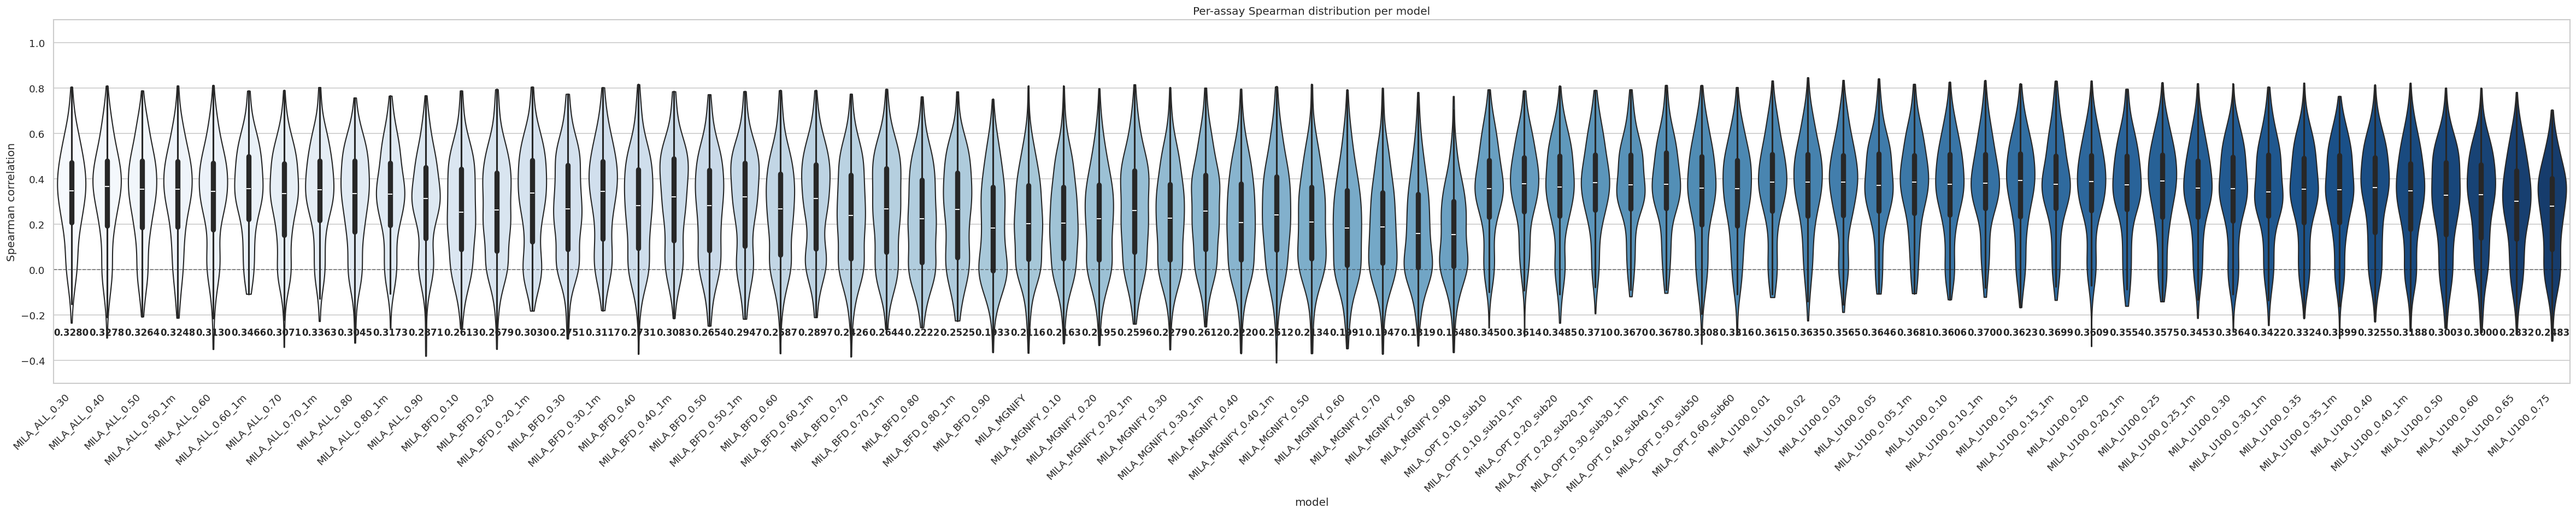

In [10]:
# Violin plot comparing models
if 'long_df' in globals() and not long_df.empty:
    # Create custom ordering by family and model size
    # Order models by year (extract year from model name)
    available_models = [m for m in long_df['model'].unique()]
    ordered_models = sorted(available_models)
    
    # Reorder the dataframe
    long_df_ordered = long_df[long_df['model'].isin(ordered_models)].copy()
    long_df_ordered['model'] = pd.Categorical(long_df_ordered['model'], categories=ordered_models, ordered=True)
    
    plt.figure(figsize=(4 + 0.5*len(ordered_models), 8))
    ax = sns.violinplot(data=long_df_ordered, y='spearman', x='model', inner='box', cut=0, palette=colors)
    ax.axhline(0.0, color='k', lw=1, ls='--', alpha=0.5)
    ax.set_ylim(-0.5, 1.1)  # Adjusted based on your data range
    
    # Add mean values as text on the plot
    for i, model in enumerate(ordered_models):
        model_data = long_df_ordered[long_df_ordered['model'] == model]['spearman']
        if not model_data.empty:
            mean_val = model_data.mean()
            ax.text(i, -0.3, f'{mean_val:.4f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_title('Per-assay Spearman distribution per model')
    ax.set_ylabel('Spearman correlation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot. Fill 'model_paths' and run the evaluation cell above first.")

### Finer grained analysis

In [11]:
AMPLIFY_120M_avg_spearman = 0.3646

In [12]:
colors = ["#845ec2", "#00c9a7"]

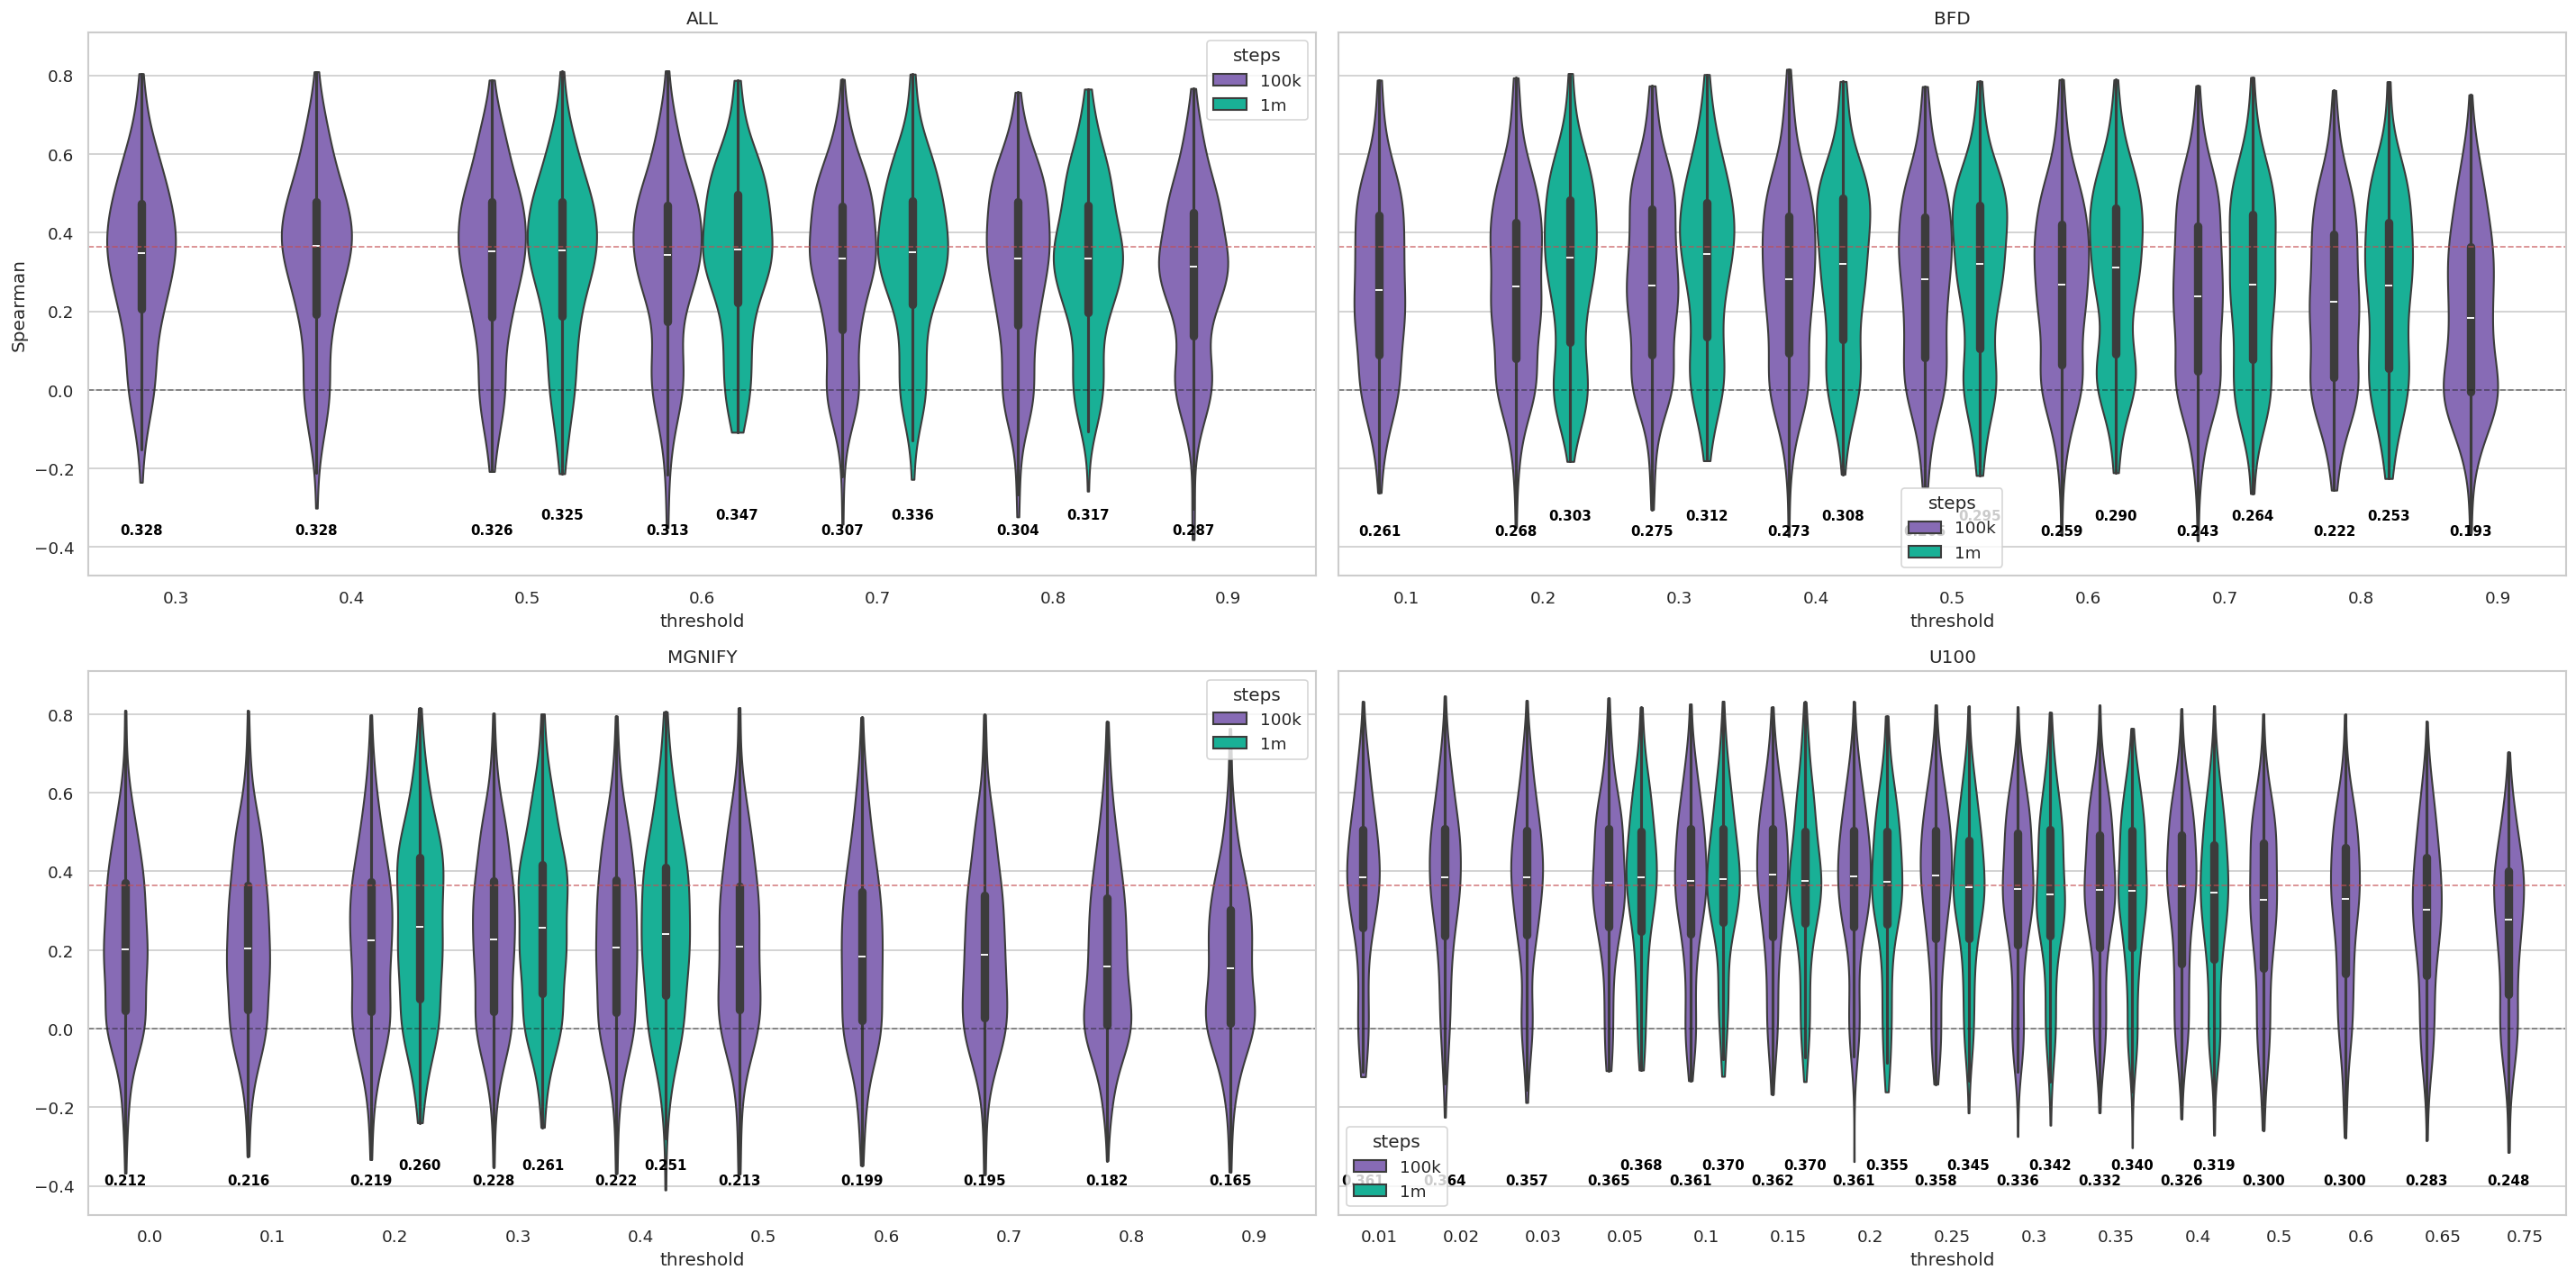

In [13]:
# Choose the enriched long df if available
df_src = None
if 'long_df_plus' in globals():
    df_src = long_df_plus.copy()
elif 'long_df' in globals():
    df_src = long_df.copy()
else:
    df_src = None

if df_src is None or df_src.empty:
    print("No data found. Ensure long_df or long_df_plus is defined.")
else:
    df_points = df_src.copy()
    # Ensure required helper columns
    if 'steps' not in df_points.columns and 'long_training' in df_points.columns:
        df_points['steps'] = df_points['long_training'].map({True: '1m', False: '100k'})
    if 'sub_ratio' not in df_points.columns:
        df_points['sub_ratio'] = np.nan
    df_points['sub_ratio'] = df_points['sub_ratio'].fillna(100).astype(int)
    # Coerce threshold to numeric for ordering
    df_points['threshold'] = pd.to_numeric(df_points['threshold'], errors='coerce')
    # Basic sanity filters
    df_points = df_points.dropna(subset=['dataset','threshold','spearman'])
    
    # Get dataset order
    dataset_order = sorted(df_points['dataset'].dropna().unique().tolist())
    # Pop OPT dataset
    if 'OPT' in dataset_order:
        dataset_order.remove('OPT')
    step_order = [s for s in ['100k','1m'] if s in df_points['steps'].unique()]
    step_palette = {s: colors[i % len(colors)] for i, s in enumerate(step_order)}

    # Create separate plots for each dataset
    sns.set_style('whitegrid')
    
    n_datasets = len(dataset_order)
    fig, axes = plt.subplots(2, 2, figsize=(6 * n_datasets, 12), sharey=True)
    axes = axes.flatten()
    if n_datasets == 1:
        axes = [axes]
    
    for i, dataset in enumerate(dataset_order):
        # Filter data for this dataset and get its specific threshold order
        dataset_data = df_points[df_points['dataset'] == dataset]
        threshold_order_ds = sorted(dataset_data['threshold'].dropna().unique().tolist())
        
        # Create violin plot for this dataset, applying custom colors
        sns.violinplot(
            data=dataset_data, 
            x='threshold', y='spearman', hue='steps',
            split=False, inner='box', cut=0,
            order=threshold_order_ds, hue_order=step_order,
            palette=step_palette, ax=axes[i]
        )
        
        axes[i].set_title(f'{dataset}')
        axes[i].set_xlabel('threshold')
        if i == 0:
            axes[i].set_ylabel('Spearman')
        else:
            axes[i].set_ylabel('')
        
        # Add mean values below each violin
        for j, threshold in enumerate(threshold_order_ds):
            for k, step in enumerate(step_order):
                subset = dataset_data[
                    (dataset_data['threshold'] == threshold) & 
                    (dataset_data['steps'] == step)
                ]
                if not subset.empty:
                    mean_val = subset['spearman'].mean()
                    # Position text below the violin
                    x_pos = j + (k - 0.5) * 0.4  # Offset for different steps
                    y_pos = axes[i].get_ylim()[0] + 0.05 * (axes[i].get_ylim()[1] - axes[i].get_ylim()[0]) + 0.04 * k
                    axes[i].text(x_pos, y_pos, f'{mean_val:.3f}', 
                               ha='center', va='bottom', fontsize=9, fontweight='bold',
                               color='black')
        axes[i].axhline(0.0, color='k', lw=1, ls='--', alpha=0.5)
        axes[i].axhline(AMPLIFY_120M_avg_spearman, color='r', lw=1, ls='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


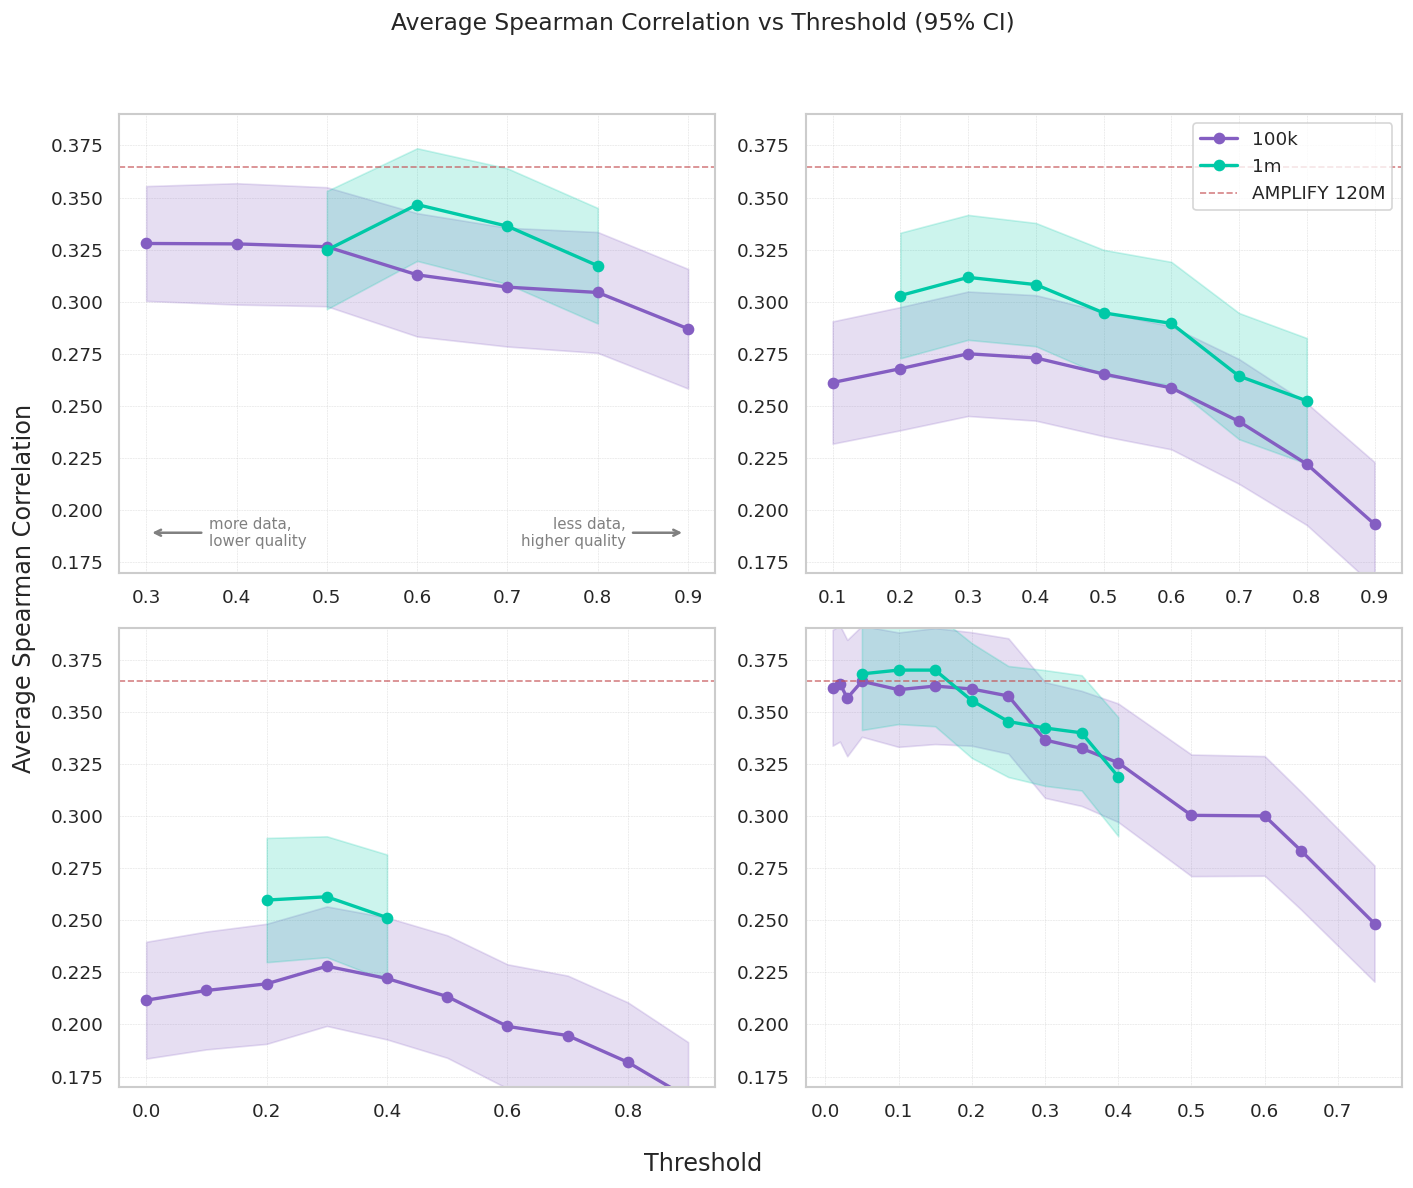

In [20]:
if 'long_df_plus' in globals() and not long_df_plus.empty:
    df_points = long_df_plus.copy()
    
    # Ensure required helper columns
    if 'steps' not in df_points.columns and 'long_training' in df_points.columns:
        df_points['steps'] = df_points['long_training'].map({True: '1m', False: '100k'})
    
    # Coerce threshold to numeric for ordering
    df_points['threshold'] = pd.to_numeric(df_points['threshold'], errors='coerce')
    df_points = df_points.dropna(subset=['dataset','threshold','spearman'])
    
    # Calculate statistics per dataset, threshold, and steps
    def confidence_interval_95(x):
        n = len(x)
        if n < 2:
            return 0
        sem = stats.sem(x)
        return sem * stats.t.ppf(0.975, n-1)  # 95% CI
    
    avg_data = (df_points
                .groupby(['dataset', 'threshold', 'steps'])['spearman']
                .agg(['count', 'mean', 'std', confidence_interval_95])
                .reset_index())
    
    # Get dataset and step order
    dataset_order = sorted(avg_data['dataset'].unique())
    if 'OPT' in dataset_order:
        dataset_order.pop(dataset_order.index('OPT'))
    step_order = sorted(avg_data['steps'].unique())
    
    # Create separate subplots for each dataset
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    if len(dataset_order) == 1:
        axes = [axes]
    
    for i, dataset in enumerate(dataset_order):
        dataset_data = avg_data[avg_data['dataset'] == dataset]
        
        for j, step in enumerate(step_order):
            step_data = dataset_data[dataset_data['steps'] == step].sort_values('threshold')
            if not step_data.empty:
                # Plot the main line
                axes[i].plot(step_data['threshold'], step_data['mean'], 
                           marker='o', linewidth=2, markersize=6, 
                           label=f"{step}", color=colors[j])
                
                # Add confidence interval
                axes[i].fill_between(step_data['threshold'], 
                                   step_data['mean'] - step_data['confidence_interval_95'],
                                   step_data['mean'] + step_data['confidence_interval_95'],
                                   alpha=0.2, color=colors[j])
        # Do not set per-axes titles or labels; use figure-level labels instead
        axes[i].grid(True, which="major", ls="--", linewidth=0.3, alpha=0.7)
        axes[i].axhline(AMPLIFY_120M_avg_spearman, color='r', lw=1, ls='--', alpha=0.7, label='AMPLIFY 120M')
        
        # Add arrows only to the first subplot (axes[0])
        if i == 0:
            xlim = axes[i].get_xlim()
            ylim = axes[i].get_ylim()
            y_arrow = ylim[0] - 0.5 * (ylim[1] - ylim[0])
        
            axes[i].annotate('more data,\nlower quality', 
                           xy=(xlim[0] + 0.05 * (xlim[1] - xlim[0]), y_arrow),
                           xytext=(xlim[0] + 0.15 * (xlim[1] - xlim[0]), y_arrow),
                           arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
                           ha='left', va='center', fontsize=9, color='gray')
            
            axes[i].annotate('less data,\nhigher quality',
                           xy=(xlim[1] - 0.05 * (xlim[1] - xlim[0]), y_arrow),
                           xytext=(xlim[1] - 0.15 * (xlim[1] - xlim[0]), y_arrow),
                           arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
                           ha='right', va='center', fontsize=9, color='gray')
        axes[i].set_ylim(0.17, 0.39)
    
    axes[1].legend(loc='upper right')
    plt.suptitle('Average Spearman Correlation vs Threshold (95% CI)', fontsize=14)
    fig.supxlabel('Threshold')
    fig.supylabel('Average Spearman Correlation')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
        
else:
    print("No data found. Ensure long_df_plus is defined.")


In [15]:
df_src['sub_ratio'].dropna().unique()

array([10., 20., 30., 40., 50., 60.])

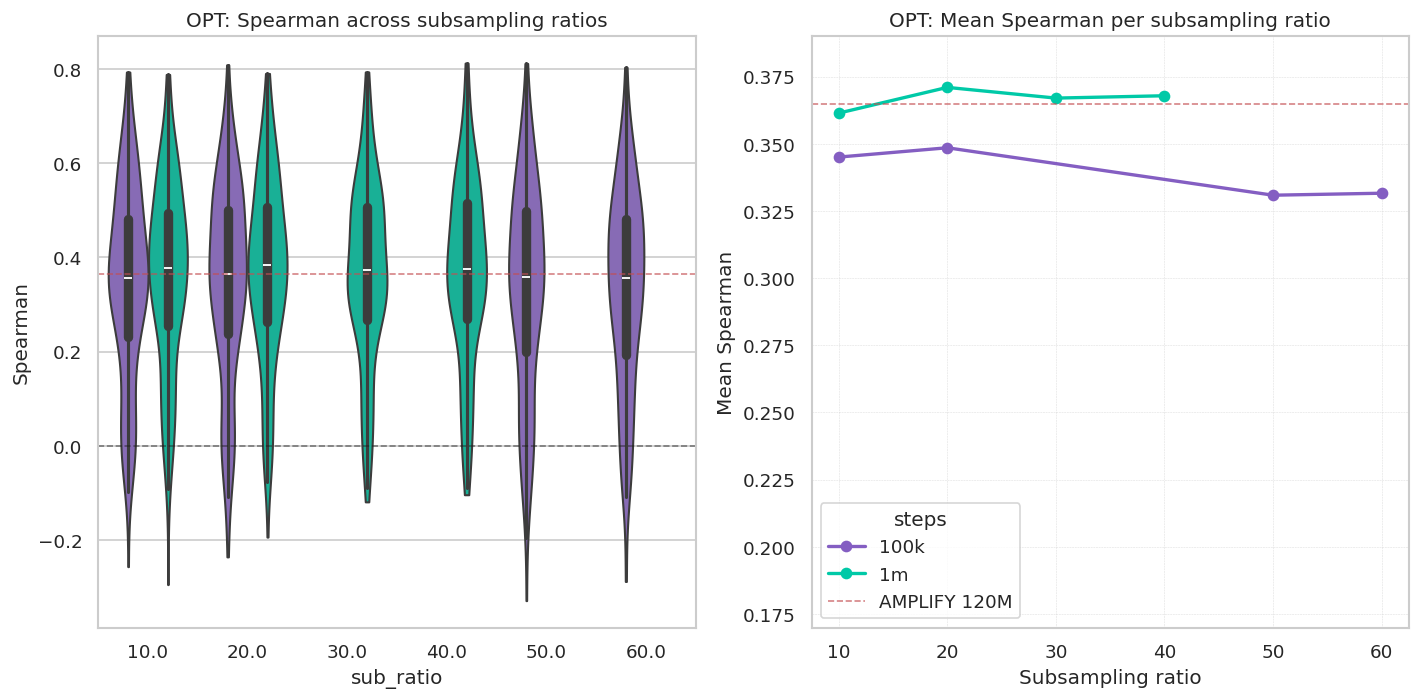

In [23]:
if df_src is None or df_src.empty:
    print("No data found for OPT plot.")
else:
    opt = df_src.copy()
    if 'steps' not in opt.columns and 'long_training' in opt.columns:
        opt['steps'] = opt['long_training'].map({True: '1m', False: '100k'})
    if 'sub_ratio' not in opt.columns:
        opt['sub_ratio'] = np.nan

    # Keep only OPT
    opt = opt[opt['dataset'].str.upper() == 'OPT'].copy()
    if opt.empty:
        print("No OPT entries found.")
    else:
        opt['sub_ratio'] = pd.to_numeric(opt['sub_ratio'], errors='coerce')
        opt = opt.dropna(subset=['sub_ratio', 'spearman', 'steps'])
        thr_order = sorted(opt['sub_ratio'].unique().tolist())
        step_order = [s for s in ['100k', '1m'] if s in opt['steps'].unique()]

        # Use same color scheme as above
        if 'step_palette' in globals():
            palette = {k: step_palette[k] for k in step_order if k in step_palette}
        elif 'colors' in globals():
            palette = {s: colors[i % len(colors)] for i, s in enumerate(step_order)}
        else:
            palette = None

        sns.set_style('whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False)

        # Upper: violin plot
        sns.violinplot(
            data=opt,
            x='sub_ratio',
            y='spearman',
            hue='steps',
            inner='box',
            cut=0,
            order=thr_order,
            hue_order=step_order,
            palette=palette,
            ax=axes[0],
            legend=False
        )
        axes[0].set_title('OPT: Spearman across subsampling ratios')
        axes[0].set_ylabel('Spearman')
        axes[0].axhline(0.0, color='k', lw=1, ls='--', alpha=0.5)
        if 'AMPLIFY_120M_avg_spearman' in globals():
            axes[0].axhline(AMPLIFY_120M_avg_spearman, color='r', lw=1, ls='--', alpha=0.7)

        # Lower: means per threshold (line plot)
        means = (opt.groupby(['sub_ratio', 'steps'])['spearman']
                 .mean()
                 .reset_index(name='mean'))
        for st in step_order:
            sdata = means[means['steps'] == st].sort_values('sub_ratio')
            axes[1].plot(
                sdata['sub_ratio'],
                sdata['mean'],
                marker='o',
                linewidth=2,
                markersize=6,
                label=st,
                color=palette.get(st) if palette else None
            )
        axes[1].set_title('OPT: Mean Spearman per subsampling ratio')
        axes[1].set_xlabel('Subsampling ratio')
        axes[1].set_ylabel('Mean Spearman')
        axes[1].grid(True, which="major", ls="--", linewidth=0.3, alpha=0.7)
        if 'AMPLIFY_120M_avg_spearman' in globals():
            axes[1].axhline(AMPLIFY_120M_avg_spearman, color='r', lw=1, ls='--', alpha=0.7, label='AMPLIFY 120M')
        axes[1].legend(loc='best', title='steps')
        axes[1].set_ylim(0.17, 0.39)

        plt.tight_layout()
        plt.show()

In [17]:
# Compute the distribution of the sequence lengths in the DMS benchmark
dms_ref_df = pd.read_csv('/home/mila/d/david.heurtel-depeiges/ProteinGym/reference_files/DMS_substitutions.csv')


In [18]:
(dms_ref_df["seq_len"]>=1024).sum()/len(dms_ref_df)

0.07373271889400922